# Character Recognition Model Building

In [1]:
from tensorflow.keras.layers.experimental.preprocessing import StringLookup
from tensorflow import keras

import random as rn
import time 
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os
np.random.seed(42)
tf.random.set_seed(42)

In [2]:
from pickle import LIST
base_path = "IAM"
words_list = []
words = open(f"{base_path}/words.txt","r").readlines()
Lst=len(words)
for i,line in enumerate(words):
    if line[0] == "#" or i==(Lst-1):
        continue
    try:
        if line.split(" ")[1] != "err":
            words_list.append(line)
    except:
        print(line)
        print("error")
        break
LEN=len(words_list)
print(LEN)

np.random.shuffle(words_list)

96455


In [3]:
for i in range(5):
    print(words_list[i])

e04-030-04-08 ok 170 1489 1499 120 39 JJ sure

n03-082-01-08 ok 166 1626 984 9 32 , ,

a01-082u-01-04 ok 172 1582 1043 234 88 IN during

m01-000-05-12 ok 193 2145 1652 109 66 PP3O her

g01-031-07-06 ok 152 1912 2038 167 59 NN booty



In [4]:
split_idx = int(0.9 * LEN)
train_samples = words_list[:split_idx]
test_samples = words_list[split_idx:]

val_split_idx = int(0.5 * len(test_samples))
validation_samples = test_samples[:val_split_idx]
test_samples = test_samples[val_split_idx:]

assert LEN == len(train_samples) + len(validation_samples) + len(test_samples)

print(f"Total training samples: {len(train_samples)}")
print(f"Total validation samples: {len(validation_samples)}")
print(f"Total test samples: {len(test_samples)}")

Total training samples: 86809
Total validation samples: 4823
Total test samples: 4823


In [5]:
base_image_path = os.path.join(base_path,"words")

def get_image_and_labels(samples):
    paths = []
    corrected_samples = []
    for (i, file_line) in enumerate(samples):
        line_split = file_line.strip()
        line_split = line_split.split(" ")
        
        image_name = line_split[0]
        partI = image_name.split("-")[0]
        partII = image_name.split("-")[1]
        img_path = os.path.join(
            base_image_path, partI, partI + "-" + partII, image_name + ".png"
        )
        
        if os.path.getsize(img_path):
            paths.append(img_path)
            corrected_samples.append(file_line.split("\n")[0])
            
    return paths, corrected_samples

train_img_paths, train_labels = get_image_and_labels(train_samples)
validation_img_paths, validation_labels = get_image_and_labels(validation_samples)
test_img_paths, test_labels = get_image_and_labels(test_samples)

In [6]:
train_img_paths[0:10]

['IAM\\words\\e04\\e04-030\\e04-030-04-08.png',
 'IAM\\words\\n03\\n03-082\\n03-082-01-08.png',
 'IAM\\words\\a01\\a01-082u\\a01-082u-01-04.png',
 'IAM\\words\\m01\\m01-000\\m01-000-05-12.png',
 'IAM\\words\\g01\\g01-031\\g01-031-07-06.png',
 'IAM\\words\\f07\\f07-081b\\f07-081b-01-06.png',
 'IAM\\words\\j07\\j07-000\\j07-000-00-03.png',
 'IAM\\words\\g06\\g06-018c\\g06-018c-04-05.png',
 'IAM\\words\\g06\\g06-011j\\g06-011j-06-06.png',
 'IAM\\words\\f04\\f04-024\\f04-024-01-06.png']

In [7]:
train_labels[0:10]

['e04-030-04-08 ok 170 1489 1499 120 39 JJ sure',
 'n03-082-01-08 ok 166 1626 984 9 32 , ,',
 'a01-082u-01-04 ok 172 1582 1043 234 88 IN during',
 'm01-000-05-12 ok 193 2145 1652 109 66 PP3O her',
 'g01-031-07-06 ok 152 1912 2038 167 59 NN booty',
 'f07-081b-01-06 ok 168 1366 924 350 88 NN gastronomy',
 'j07-000-00-03 ok 136 887 753 134 47 NNS units',
 'g06-018c-04-05 ok 182 1298 1438 96 58 ATI The',
 'g06-011j-06-06 ok 182 1222 1785 146 95 CC and',
 'f04-024-01-06 ok 183 1104 981 60 70 IN in']

In [8]:
train_labels_cleaned = []
characters = set()
max_len=0

for label in train_labels:
    label = label.split(" ")[-1].strip()
    for char in label:
        characters.add(char)
    
    max_len = max(max_len, len(label))
    train_labels_cleaned.append(label)

print("Maximum length: ", max_len)
print("Vocab size: ", len(characters))

train_labels_cleaned[:10]

Maximum length:  21
Vocab size:  78


['sure',
 ',',
 'during',
 'her',
 'booty',
 'gastronomy',
 'units',
 'The',
 'and',
 'in']

In [9]:
print(characters)

{'p', 'k', '#', 'U', 'S', '-', "'", 'w', 'a', '+', 'W', 'L', 'G', 'X', '?', '0', 'V', 'P', 'N', 'b', 'v', '&', 'R', '7', '6', '"', '3', 'h', 's', '.', '*', 'u', 'x', 'K', '!', 'd', 'i', 't', 'n', 'H', '1', 'z', 'C', ',', '/', 'I', 'E', 'g', 'Z', 'm', 'q', 'y', 'c', 'l', 'o', '(', 'B', 'r', 'e', ')', '4', '5', 'j', 'J', ';', '8', 'Y', 'T', '9', 'F', 'A', '2', 'D', 'Q', 'f', ':', 'O', 'M'}


In [10]:
def clean_labels(labels):
    cleaned_labels = []
    for label in labels:
        label = label.split(" ")[-1].strip()
        cleaned_labels.append(label)
    return cleaned_labels

validation_labels_cleaned = clean_labels(validation_labels)
test_labels_cleaned = clean_labels(test_labels)

In [11]:
AUTOTUNE = tf.data.AUTOTUNE

char_to_num = StringLookup(vocabulary=list(characters), mask_token=None)

num_to_char = StringLookup(vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True)

In [12]:
def distortion_free_resize(image, img_size):
    w, h = img_size
    image = tf.image.resize(image, size = (h,w), preserve_aspect_ratio=True)
    
    pad_height = h - tf.shape(image)[0]
    pad_width = w - tf.shape(image)[1]
    if pad_height % 2 != 0:
        height = pad_height // 2
        pad_height_top = height + 1
        pad_height_bottom = height
    else:
        pad_height_top = pad_height_bottom = pad_height // 2
        
    if pad_width % 2 != 0:
        width = pad_width // 2
        pad_width_left = width + 1
        pad_width_right = width
    else:
        pad_width_left = pad_width_right = pad_width // 2
        
    image = tf.pad(
        image,
        paddings=[
            [pad_height_top, pad_height_bottom],
            [pad_width_left, pad_width_right],
            [0,0],
        ],
    )
    
    image = tf.transpose(image, perm=[1,0,2])
    image = tf.image.flip_left_right(image)
    
    return image


In [13]:
batch_size = 64
padding_token = 99
image_width = 128
image_height = 32

def preprocess_image(image_path, img_size=(image_width, image_height)):
    image = tf.io.read_file(image_path)
    image = tf.io.decode_png(image,1)
    image = distortion_free_resize(image, img_size)
    image = tf.cast(image, tf.float32) / 255.0
    return image

def vectorize_label(label):
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    length = tf.shape(label)[0]
    pad_amount = max_len - length
    label = tf.pad(label, paddings=[[0, pad_amount]], constant_values=padding_token)
    return label

def process_images_labels(image_path, label):
    image = preprocess_image(image_path)
    label = vectorize_label(label)
    return {"image": image, "label": label}

def prepare_dataset(image_paths, labels):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels)).map(
        process_images_labels, num_parallel_calls=AUTOTUNE
    )
    return dataset.batch(batch_size).cache().prefetch(AUTOTUNE)


In [14]:
train_ds = prepare_dataset(train_img_paths, train_labels_cleaned)
validation_ds = prepare_dataset(validation_img_paths, validation_labels_cleaned)
test_ds = prepare_dataset(test_img_paths, test_labels_cleaned)

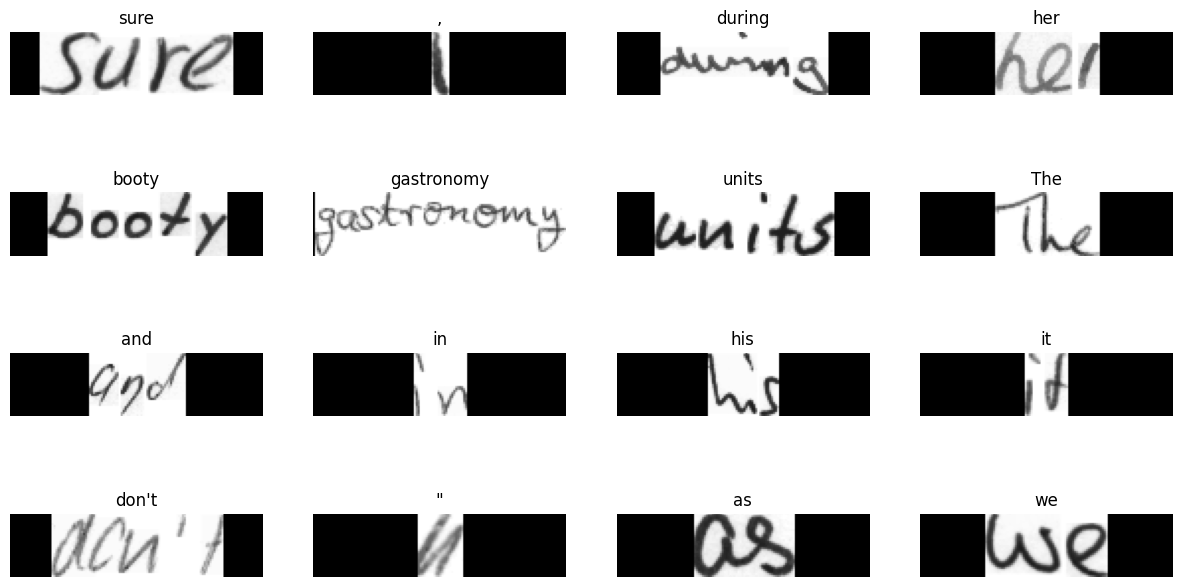

In [15]:
for data in train_ds.take(1):
    images, labels = data["image"], data["label"]
    
    _, ax = plt.subplots(4, 4, figsize=(15,8))
    
    for i in range(16):
        img = images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]
        
        label = labels[i]
        indices = tf.gather(label, tf.where(tf.math.not_equal(label, padding_token)))
        
        label = tf.strings.reduce_join(num_to_char(indices))
        label = label.numpy().decode("utf-8")
        
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")
        
plt.show()

In [16]:
class CTCLayer(keras.layers.Layer):
    def __init__(self, name=None, **kwargs):
        super().__init__(name=name, **kwargs)
        self.loss_fn = keras.backend.ctc_batch_cost
    
    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")
        
        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)
        
        return y_pred

def build_model():
    input_img = keras.Input(shape=(image_width, image_height, 1), name="image")
    labels = keras.layers.Input(name="label", shape=(None,))
    
    x = keras.layers.Conv2D(
        32,
        (3,3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x = keras.layers.MaxPooling2D((2,2), name="pool1")(x)
    
    x = keras.layers.Conv2D(
        64,
        (3,3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = keras.layers.MaxPooling2D((2,2), name="pool2")(x)
    
    new_shape = ((image_width // 4), (image_height // 4) * 64)
    x= keras.layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x= keras.layers.Dense(64, activation="relu", name="dense1")(x)
    x= keras.layers.Dropout(0.2)(x)
    
    x= keras.layers.Bidirectional(
        keras.layers.LSTM(128, return_sequences=True, dropout=0.25)
    )(x)
    x= keras.layers.Bidirectional(
        keras.layers.LSTM(64, return_sequences=True, dropout=0.25)
    )(x)
    
    x= keras.layers.Dense(
        len(char_to_num.get_vocabulary()) + 2, activation="softmax", name="dense2"
    )(x)
    
    output = CTCLayer(name="ctc_loss")(labels, x)
    
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="handwriting_recognizer"
    )
    
    opt = keras.optimizers.Adam()
    
    model.compile(optimizer=opt)
    
    return model

In [17]:
model = build_model()
model.summary()

Model: "handwriting_recognizer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 128, 32, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 Conv1 (Conv2D)                 (None, 128, 32, 32)  320         ['image[0][0]']                  
                                                                                                  
 pool1 (MaxPooling2D)           (None, 64, 16, 32)   0           ['Conv1[0][0]']                  
                                                                                                  
 Conv2 (Conv2D)                 (None, 64, 16, 64)   18496       ['pool1[0][0

In [18]:
validation_images = []
validation_labels = []

for batch in validation_ds:
    validation_images.append(batch["image"])
    validation_labels.append(batch["label"])

In [19]:
def calculate_edit_distance(labels, predictions):
    saprse_labels = tf.cast(tf.sparse.from_dense(labels), dtype=tf.int64)
    
    input_len = np.ones(predictions.shape[0]) * predictions.shape[1]
    predictions_decoded = keras.backend.ctc_decode(
        predictions, input_length=input_len, greedy=True
    )[0][0][:, :max_len]
    sparse_predictions = tf.cast(
        tf.sparse.from_dense(predictions_decoded), dtype=tf.int64
    )
    
    edit_distances = tf.edit_distance(
        sparse_predictions, saprse_labels, normalize=False
    )
    
    return tf.reduce_mean(edit_distances)

class EditDistanceCallback(keras.callbacks.Callback):
    def __init__(self, pred_model):
        super().__init__()
        self.prediction_model = pred_model
        
    def on_epoch_end(self, epoch, logs=None):
        edit_distances = []
        
        for i in range(len(validation_images)):
            labels = validation_labels[i]
            predictions = self.prediction_model.predict(validation_images[i])
            edit_distances.append(calculate_edit_distance(labels, predictions).numpy())
        
        print(
            f"Mean edit distance for epoch {epoch + 1}: {np.mean(edit_distances):.4f}"
        )

In [20]:
epochs = 20
model = build_model()
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
edit_distance_callback = EditDistanceCallback(prediction_model)

history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=epochs,
    callbacks=[edit_distance_callback],
)

Epoch 1/20
1/1 [==============================] - 1s 891ms/step
Mean edit distance for epoch 1: 20.5172
1357/1357 [==============================] - 348s 252ms/step - loss: 13.4906 - val_loss: 11.5894
Epoch 2/20
1/1 [==============================] - 0s 27ms/step
Mean edit distance for epoch 2: 20.0327
1357/1357 [==============================] - 278s 205ms/step - loss: 10.2840 - val_loss: 9.0667


Epoch 3/20
1/1 [==============================] - 0s 27ms/step
Mean edit distance for epoch 3: 19.4521
1357/1357 [==============================] - 277s 204ms/step - loss: 8.2010 - val_loss: 7.0020
Epoch 4/20
1/1 [==============================] - 0s 27ms/step
Mean edit distance for epoch 4: 18.7223
1357/1357 [==============================] - 273s 202ms/step - loss: 6.4029 - val_loss: 5.2562


Epoch 5/20
1/1 [==============================] - 0s 27ms/step
Mean edit distance for epoch 5: 18.2847
1357/1357 [==============================] - 272s 201ms/step - loss: 5.1679 - val_loss: 4.1103
Epoch 6/20
1/1 [==============================] - 0s 27ms/step
Mean edit distance for epoch 6: 18.0574
1357/1357 [==============================] - 277s 204ms/step - loss: 4.4547 - val_loss: 3.5656


Epoch 7/20
1/1 [==============================] - 0s 27ms/step
Mean edit distance for epoch 7: 17.8870
1357/1357 [==============================] - 275s 203ms/step - loss: 3.9813 - val_loss: 3.1831
Epoch 8/20
1/1 [==============================] - 0s 26ms/step
Mean edit distance for epoch 8: 17.8415
1357/1357 [==============================] - 272s 200ms/step - loss: 3.6444 - val_loss: 2.9773


Epoch 9/20
1/1 [==============================] - 0s 28ms/step
Mean edit distance for epoch 9: 17.7666
1357/1357 [==============================] - 271s 200ms/step - loss: 3.3746 - val_loss: 2.7228
Epoch 10/20
1/1 [==============================] - 0s 27ms/step
Mean edit distance for epoch 10: 17.6700
1357/1357 [==============================] - 276s 204ms/step - loss: 3.1683 - val_loss: 2.5400


Epoch 11/20
1/1 [==============================] - 0s 29ms/step
Mean edit distance for epoch 11: 17.6570
1357/1357 [==============================] - 275s 202ms/step - loss: 3.0114 - val_loss: 2.4741
Epoch 12/20
1/1 [==============================] - 0s 27ms/step
Mean edit distance for epoch 12: 17.5854
1357/1357 [==============================] - 277s 204ms/step - loss: 2.8701 - val_loss: 2.3286


Epoch 13/20
1/1 [==============================] - 0s 30ms/step
Mean edit distance for epoch 13: 17.5540
1357/1357 [==============================] - 281s 207ms/step - loss: 2.7527 - val_loss: 2.2387
Epoch 14/20
1/1 [==============================] - 0s 31ms/step
Mean edit distance for epoch 14: 17.5295
1357/1357 [==============================] - 283s 209ms/step - loss: 2.6470 - val_loss: 2.1927


Epoch 15/20
1/1 [==============================] - 0s 31ms/step
Mean edit distance for epoch 15: 17.5326
1357/1357 [==============================] - 284s 209ms/step - loss: 2.5628 - val_loss: 2.1242
Epoch 16/20
1/1 [==============================] - 0s 31ms/step
Mean edit distance for epoch 16: 17.5569
1357/1357 [==============================] - 288s 212ms/step - loss: 2.4813 - val_loss: 2.1738


Epoch 17/20
1/1 [==============================] - 0s 32ms/step
Mean edit distance for epoch 17: 17.4592
1357/1357 [==============================] - 291s 215ms/step - loss: 2.4109 - val_loss: 2.0425
Epoch 18/20
1/1 [==============================] - 0s 32ms/step
Mean edit distance for epoch 18: 17.4535
1357/1357 [==============================] - 296s 218ms/step - loss: 2.3419 - val_loss: 1.9749


Epoch 19/20
1/1 [==============================] - 0s 33ms/step
Mean edit distance for epoch 19: 17.4459
1357/1357 [==============================] - 298s 220ms/step - loss: 2.2874 - val_loss: 1.9553
Epoch 20/20
1/1 [==============================] - 0s 34ms/step
Mean edit distance for epoch 20: 17.4196
1357/1357 [==============================] - 299s 220ms/step - loss: 2.2349 - val_loss: 1.8925


# Results: (Ch. Rec. Model testing on Test_DS)

In [21]:
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1] 
    
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_len
    ]
    
    output_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text

2/2 [==============================] - 0s 35ms/step


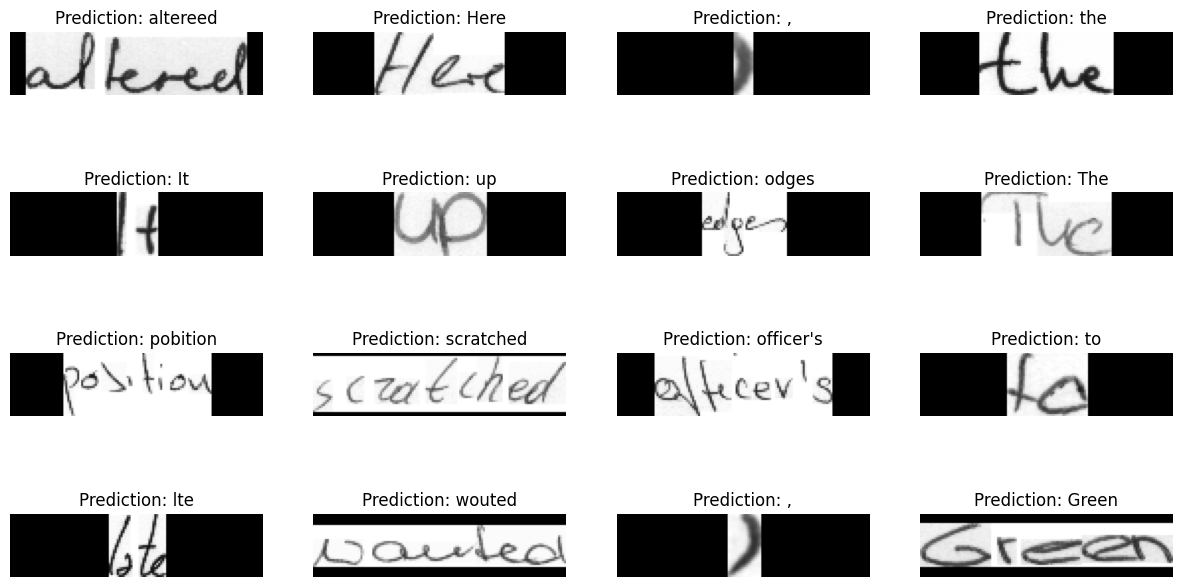

In [22]:
for batch in test_ds.take(1):
    batch_images = batch["image"]
    _, ax = plt.subplots(4, 4, figsize=(15,8))
    
    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)
    
    for i in range(16):
        img = batch_images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]
        
        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")
        
plt.show()

# Testing (on Own_Handwriting)

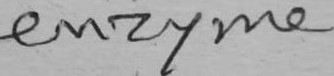

In [23]:
from PIL import Image
im_path="my_handwriting_1.jpg"
Image.open(im_path)

(128, 32, 1)


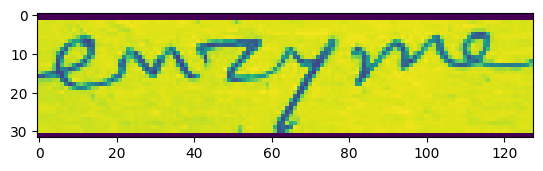

In [24]:
import cv2

im = preprocess_image(im_path)
print(im.shape)
imz = tf.image.flip_left_right(im)
imz = tf.transpose(imz, perm=[1, 0, 2])
#imz = (imz * 255.0).numpy().clip(0, 255).astype(np.uint8)
imz = imz[:, :, 0]
plt.imshow(imz)
plt.show()

In [25]:
result = prediction_model.predict(np.expand_dims(im,axis=0))

1/1 [==============================] - 0s 20ms/step


In [26]:
res_txt = decode_batch_predictions(result)
print(res_txt[0])

eee


# Results plot (for Ch. Rec. Loss)

In [27]:
def plotgraph(epochs, acc, val_acc):
    # Ploting training & validation accuracy values
    plt.plot(epochs, acc, 'b')
    plt.plot(epochs, val_acc, 'r')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

In [28]:
#acc = history.history['accuracy']
#val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,len(loss)+1)

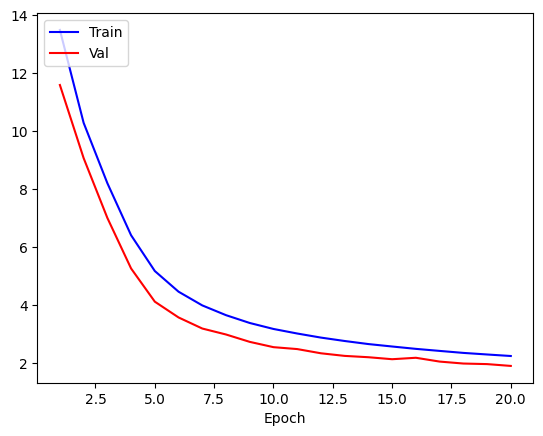

In [29]:
plotgraph(epochs, loss, val_loss)

# Preparing a Random Sample:

In [30]:
data_dir = r"C:\Users\SAYAN\Desktop\All_in_All\Juppiter\iam-handwritten-forms-dataset\data"

p=[]       #---Separating Data, Images
q=[]
for i in os.listdir(data_dir) :
    p.append(i)
    q.append(os.listdir(data_dir+'\\'+i))

In [31]:
def showIm(image):                                   #---Function to plot an image with proper colour scheme    
    image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)     #---Fixing colour scheme
    plt.imshow(image)                                #---Ploting the Image
    plt.show()


Generated Image File Name: d04-032.png 		(Data Folder: 187 )


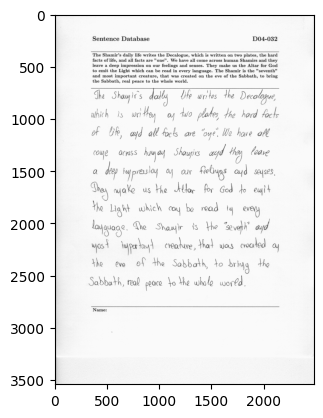

(3542, 2479, 3)


In [32]:
#rn --> is the random library
ranImDir=p[rn.randint(0,(len(p)-1))]                                     #---Picks a Random Image Data Folder
imgFile=data_dir+'\\'+ ranImDir +'\\'+ q[p.index(ranImDir)][0]
ranIm=cv2.imread(imgFile)                                                #---Reads the first Image in 'ranImDir'

print("\nGenerated Image File Name:", q[p.index(ranImDir)][0], "\t\t(Data Folder:",ranImDir,")")
showIm(ranIm)
print(ranIm.shape)

(3542, 2479, 3)


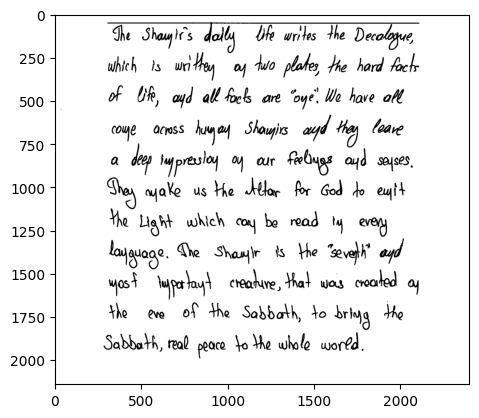

In [33]:
import cv2

Im=cv2.imread(imgFile)
#Im=cv2.imread("sam_hand_writing.jpg")

print(Im.shape)

def noiseRem(image):
    kernel=np.ones((1,1), np.uint8)
    image=cv2.dilate(image,kernel,iterations=1)
    kernel=np.ones((3,3), np.uint8)
    image=cv2.erode(image,kernel,iterations=1)
    image=cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)
    return(image)

cropIm=Im[660:2800, 40:(Im.shape[1]-40)]                                          #Cropping Useful Data Portion
grayIm=cv2.cvtColor(cropIm, cv2.COLOR_RGB2GRAY)                                   #Grayscaling

ret,thresIm=cv2.threshold(grayIm,200,255,cv2.THRESH_BINARY)                       #Thresholding
noiseRemIm=noiseRem(thresIm)                                                      #Noise removal

showIm(noiseRemIm)


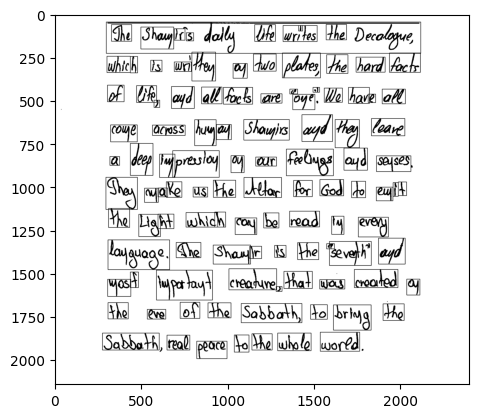

In [34]:
#this method returns a list as [x,y,x+w,y+h] for every Region of Interest(Scanned Word Segments)
def word_segm(The_Image):
    noiseRemIm=The_Image.copy()
    SegKernel = np.ones((3,15), np.uint8)
    invIm=cv2.bitwise_not(noiseRemIm)                 #---Inverting image for contouring in later stage
    diltIm=cv2.dilate(invIm,SegKernel,iterations=1)   #---Dilating the words to make Region Of Interest

    preIm=noiseRemIm.copy()

    words_list=[]

    (contours, heirarchy) = cv2.findContours(diltIm.copy(),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)   #LineContouring
    srtCntLines = sorted(contours,key = lambda cntr: cv2.boundingRect(cntr)[1])                       #Sorting Lines in order

    for line in srtCntLines:

        x, y, w, h = cv2.boundingRect(line)                                     #---Region of interest for each line
        roiL = diltIm[y:y+h,x:x+w]                                              #---sorting the results

        (cnt, heirarchy) = cv2.findContours(roiL.copy(),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)  #WordContouring on each line
        srtCntWords = sorted(cnt,key = lambda cntr: cv2.boundingRect(cntr)[0])                    #Sorting words in each line

        for word in srtCntWords:

            x2, y2, w2, h2 = cv2.boundingRect(word)                             #---Separating the Words

            if cv2.contourArea(word)<600 or h2<15:                              #---Elemenating impurities
                continue
            words_list.append([x+x2, y+y2, x+x2+w2, y+y2+h2])
            cv2.rectangle(preIm,(x+x2, y+y2),(x+x2+w2, y+y2+h2), (0,0,0),2)     #---Marking Words

    showIm(preIm)    #Printing Results
    
    return words_list

BodyWordList = word_segm(noiseRemIm)


Number of ROI's:   117

Printing first 3 ROIs:--

ROI at index 0


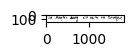

ROI at index 1


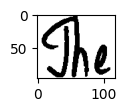

ROI at index 2


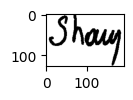

In [35]:
num_of_rois = len(BodyWordList)
print("Number of ROI's:  ",num_of_rois)
N=3
print(f"\nPrinting first {N} ROIs:--\n")

#an Example for rois that we will be working on
for i in range(N):
    ranROI=i
    #ranROI=rn.randint(0,(num_of_rois-1))
    print("ROI at index", ranROI)
    ROIindexes=BodyWordList[ranROI]
    ROIimg=noiseRemIm[ROIindexes[1]:ROIindexes[3],ROIindexes[0]:ROIindexes[2]]
    plt.figure(figsize=(1,1))
    plt.imshow(cv2.cvtColor(ROIimg, cv2.COLOR_BGR2RGB))
    plt.show()

# Character Recognizer Func. (Intermediate Step)

In [36]:
#prepares and then returns images for character recognition
def prep_image(image, img_size=(image_width, image_height)):
  image = tf.convert_to_tensor(np.expand_dims(image,axis=2))
  image = distortion_free_resize(image, img_size)
  image = tf.cast(image, tf.float32) / 255.0
  return image

In [37]:
#predicts and returns the decoded string
def pred_chars(TheImg):
    TheImg=prep_image(TheImg)
    probability=prediction_model.predict(np.expand_dims(TheImg,axis=0),verbose=0)
    return decode_batch_predictions(probability)[0]

# Trait 1: Health Fitness: (Checking for p - loop and y - stroke)

In [38]:
from keras.models import load_model
pModel = load_model('model_p_acc_0.9545454382896423.hdf5')
yModel = load_model('model_y_acc_0.9583333134651184.hdf5')

In [39]:
time.sleep(0.2) # !!Do not Remove!! Its just to avoid some fast processing error

p_loop=[]
y_stroke=[]

for i in range(num_of_rois):
    print("ROIs processed:\t",str((i+1))+"/"+str(num_of_rois),end="\r")
    ROIindexes=BodyWordList[i]
    ROIimg=noiseRemIm[ROIindexes[1]:ROIindexes[3],ROIindexes[0]:ROIindexes[2]]
    word_x = pred_chars(ROIimg)
    if 'p' in word_x or 'y' in word_x:
        h,w=ROIimg.shape
        fctr=w/h
        new_h=128
        new_w=int(new_h*fctr)
        ROIimg=cv2.resize(ROIimg,(new_w, new_h))   #resizing the image as new hight of 128
        count=0
        s=0
        while (s+128)<=new_w:                      #looping to the end of the word with 128*128 kernel, 64 stride
            img=ROIimg[:,s:s+128]
            txt = pred_chars(img)
            if 'p' in txt:
                #print('found p')
                x=cv2.merge((img,img,img))
                p_loop.append(x)
            if 'y' in txt:
                #print('found y')
                x=cv2.merge((img,img,img))
                y_stroke.append(x)
            s+=64
            if count==1:
                break
            if s+128>new_w:
                if i!=0:
                    s=new_w-128
                count=1
                
#printing results for p loops
#PAL = Physical Activity Level

print("\n________________________________\n")
if p_loop!=[]:
    p_res=np.transpose(pModel.predict(np.array(p_loop),verbose=0))
    ls=np.average(p_res[0])
    nls=np.average(p_res[1])
    print("More Loops : \t%0.4f%%"%(100*ls))
    print("Less Loops : \t%0.4f%%"%(100*nls))
    PAL=100*ls + nls
    print("\n(In scale of 0-99)\nWish for Physical Activity: \t%0.4f"%(PAL-1))
else:
    print("!!!!! Need more APPROPRIATE DATA for prediction !!!!!")

print("________________________________")
                
#printing results for y strokes
#CSI = Chance of stomach Issue

print("\n________________________________\n")
if y_stroke!=[]:
    y_res=np.transpose(yModel.predict(np.array(y_stroke),verbose=0))
    le=np.average(y_res[0])
    st=np.average(y_res[1])
    print("Left Stroke     : \t%0.2f%%"%(100*le))
    print("Straight Stroke : \t%0.2f%%"%(100*st))
    CSI= 100*le + st
    print("\nChance of Stomach related issues\n/illness due to Stress/Frustration: \t%0.2f%%"%(CSI-1))
else:
    print("!!!!! Need more APPROPRIATE DATA for prediction !!!!!")

print("________________________________")


ROIs processed:	 117/117
________________________________

More Loops : 	16.6667%
Less Loops : 	83.3333%

(In scale of 0-99)
Wish for Physical Activity: 	16.5000
________________________________

________________________________

Left Stroke     : 	0.00%
Straight Stroke : 	100.00%

Chance of Stomach related issues
/illness due to Stress/Frustration: 	0.00%
________________________________


In [40]:
#PAL is directly proportional to the person's fitness
#CSI is inversly proportional to the person's fitness
#Fitness Ratio = PAL / CSI
Fr=PAL/CSI

print("\nFitness :\t",end=" ")
if CSI>25:
    if Fr<=(1/3):
        print("Needs Medical attention")
    elif Fr<=(1/2):
        print("May be Ill")
    elif Fr<=(2):
        print("Normal")
    else:
        print("fit")
else:
    print("fit")


Fitness :	 fit


# Trait 2: Attaintivity: (Checking for Relative Size of Handwriting)

In [41]:
time.sleep(0.2) # !!Do not Remove!! Its just to avoid some fast processing error

#The Relative size of Handwriting, measured for graphological analysis (mainly the size of middle zone)
sizes=[]

for i in range(num_of_rois):
    print("ROIs processed:\t",str((i+1))+"/"+str(num_of_rois),end="\r")
    ROIindexes=BodyWordList[i]
    ROIimg=noiseRemIm[ROIindexes[1]:ROIindexes[3],ROIindexes[0]:ROIindexes[2]]
    ld,_ = ROIimg.shape
    
    #as an image(2D) can also be potraied as a matrix (in a row-column form)
    #d counts the number of black points for each rows on the scanned ROI (Region Of Interest)
    d=list(map(lambda a: list(a).count(0),ROIimg))
    
    #Following code works on the average number of balck points in a row,,
    #From the first and last row, where we are getting more than av. black point number, its limiting middle zone.
    #therefore, the distance between these two rows is our width of the middle zone of the handwritten word. (in px)
    #the average number of black points = the average no. of black points per row for that specific ROI - error
    #a certain fixed value(5) is deducted for the error in pixels due to skewness in words. (not calculated currectly)
    #Moreover, this 5 is deduced cause the skewness, spreads black points of middle zone, over upwards and downwards.
    #Overall, which increases width of middle zone.
    av=np.average(d)-5
    
    #cst = start row of the middle zone
    #cla = last row of the middle Zone
    cst=(-1)
    cla=(-1)
    for i in range(ld):
        if d[i]>=av and cst==(-1):
            cst=i
        if d[ld-i-1]>=av and cla==(-1):
            cla=ld-i-1
    sizes.append(cla-cst+1)

size_px=np.average(sizes)
print("\n\nAverage Measure of Size:  %d px (approx.)"%(np.rint(size_px)))

h,_,_ = ranIm.shape
dpi= h/11.7     #assuming that scanned paper is a A4 size
const=dpi/25.4  #example 3mm = 3*const pixels
size_mm=size_px/const
print('Size in mm:\t\t  %0.3f mm'%size_mm)


print("\nAttaitivity Scale:\t",end="")
if size_mm<0:
    print("Something unusual happened.")
elif size_mm<2.2:
    print("More Attentive")
#elif size_mm<=3.2:
#    print("Normal Attaintivity")
elif size_mm<5:
    print("Normal Attaintivity")
else:
    print("Less Attaintive")

ROIs processed:	 117/117

Average Measure of Size:  52 px (approx.)
Size in mm:		  4.358 mm

Attaitivity Scale:	Normal Attaintivity


# Trait 3: Extrovert-Introvert-Balanced (By Word Spacing)

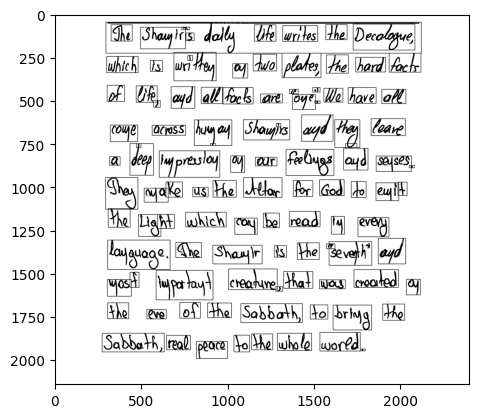

In [42]:
SegKernel = np.ones((1,150), np.uint8)
invIm=cv2.bitwise_not(noiseRemIm)
diltIm=cv2.dilate(invIm,SegKernel,iterations=1)
SegKernel2 = np.ones((1,20), np.uint8)
diltIm2=cv2.dilate(invIm,SegKernel2,iterations=1)

preIm=noiseRemIm.copy()

(contours, heirarchy) = cv2.findContours(diltIm.copy(),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
srtCntLines = sorted(contours,key = lambda cntr: cv2.boundingRect(cntr)[1])

w_list=[]
width_list=[]
ind=-1

for line in srtCntLines:

    x, y, w, h = cv2.boundingRect(line)
    if w<300 or h<=15:
        continue
    roiL = diltIm2[y:y+h,x:x+w]

    (cnt2, heirarchy2) = cv2.findContours(roiL.copy(),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
    srtCntWords2 = sorted(cnt2,key = lambda cntr2: cv2.boundingRect(cntr2)[0])
    
    w_list.append([])
    ind+=1
    #nu=1
    for word in srtCntWords2:

        x2, y2, w2, h2 = cv2.boundingRect(word)
        
        if h2<10:
            continue
            
        w_list[ind].append([x2,w2])
        roiIm=roiL[y2:y2+h2,x2:x2+w2]
        width_list.append(w2/len(pred_chars(roiIm)))
        cv2.rectangle(preIm,(x+x2, y+y2),(x+x2+w2, y+y2+h2), (0,0,0),2)
        #cv2.putText(preIm,str(nu),(x+x2+10,y+y2),cv2.FONT_HERSHEY_SIMPLEX,2,(0,0,0),2)
        #nu+=1
        
showIm(preIm)

In [43]:
#Average Word-Spacing

k_list=[abs((i[j][0]+i[j][1])-i[j+1][0]) for i in w_list for j in range(len(i)-1)]
aws=np.average(k_list)

#Average Character Length

acl=np.average(width_list)

#average number of characters between two words(parameter for measure of WS) = ratio(aws,acl)
ratio=aws/acl
print("Number of words(can be fit between two words): %0.4f\n"%ratio)

if ratio<=0.5:
    print("Extrovert")
elif ratio<1:
    print("Balanced")
else:
    print("Introvert")

Number of words(can be fit between two words): 1.4588

Introvert


# Comparing the 'p-loops' and 'y-strokes' model

### Preparing Custom Test Dataset:

In [44]:
from sklearn.metrics import classification_report,confusion_matrix
import itertools

def noiseRem(image):
    kernel=np.ones((1,1), np.uint8)
    image=cv2.dilate(image,kernel,iterations=1)
    kernel=np.ones((3,3), np.uint8)
    image=cv2.erode(image,kernel,iterations=1)
    image=cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)
    return(image)

def prep_im(shapesIm):
    grayIm=cv2.cvtColor(shapesIm, cv2.COLOR_RGB2GRAY)                                        #Grayscaling
    ret,thresIm=cv2.threshold(grayIm,200,255,cv2.THRESH_BINARY)                            #Thresholding
    return(noiseRem(thresIm))                                                           #Noise removal


In [45]:
def process_im(image):
    x=cv2.resize(image,(128,128))
    return cv2.merge((x,x,x))

In [46]:
clss=[]
pclss = ['loop','no_loop']
yclss = ['left','straight']

In [47]:
p_test=[[],[]]
y_test=[[],[]]

for ltr in 'py':
    if ltr=='p':
        clss=pclss
    else:
        clss=yclss
    for i in range(2):
        im_dir='./py_test/'+ltr+'/'+clss[i]
        for file in os.listdir(im_dir):
            im=cv2.imread(os.path.join(im_dir,file))
            im=process_im(prep_im(im))
            if ltr=='p':
                p_test[0].append(im)
                p_test[1].append(i)
            if ltr=='y':
                y_test[0].append(im)
                y_test[1].append(i)

### CNN Model for 'p-loops': (Analysis)

In [48]:
Y_pred = pModel.predict(np.array(p_test[0]), verbose=0)
y_pred = np.argmax(Y_pred, axis=1)
print("Predicting Custom Test Dataset (Results): ", *y_pred,end="\n\n")

print(classification_report(np.array(p_test[1]), y_pred,target_names=pclss))

Predicting Custom Test Dataset (Results):  1 0 1 0 0 0 1 0 0 0 1 0 1 1 1 1 1 1 0 1

              precision    recall  f1-score   support

        loop       0.78      0.70      0.74        10
     no_loop       0.73      0.80      0.76        10

    accuracy                           0.75        20
   macro avg       0.75      0.75      0.75        20
weighted avg       0.75      0.75      0.75        20



In [49]:
cm=confusion_matrix(np.array(p_test[1]), y_pred)

In [50]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(3,3))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


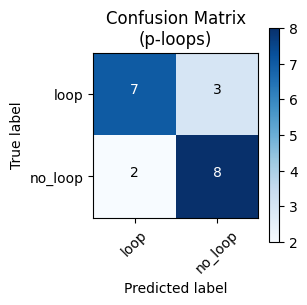

In [51]:
plot_confusion_matrix(cm=cm, classes=pclss, title='Confusion Matrix\n(p-loops)')

### CNN Model for 'y-strokes': (Analysis)

In [52]:
Y_pred = yModel.predict(np.array(y_test[0]), verbose=0)
y_pred = np.argmax(Y_pred, axis=1)
print("Predicting Custom Test Dataset (Results): ", *y_pred,end="\n\n")

print(classification_report(np.array(y_test[1]), y_pred,target_names=yclss))

Predicting Custom Test Dataset (Results):  0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 1 1 1

              precision    recall  f1-score   support

        left       0.64      0.90      0.75        10
    straight       0.83      0.50      0.62        10

    accuracy                           0.70        20
   macro avg       0.74      0.70      0.69        20
weighted avg       0.74      0.70      0.69        20



In [53]:
cm=confusion_matrix(np.array(y_test[1]), y_pred)

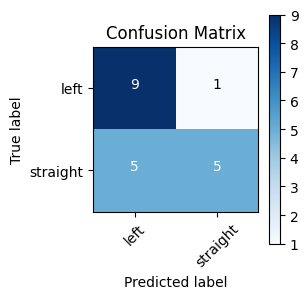

In [54]:
plot_confusion_matrix(cm=cm, classes=yclss, title='Confusion Matrix')